# Driving the Kinect2 from Python

In this notebook we will demonstrate how to use the ``freenect2`` module with Python.

In [1]:
# Use IPython's built in %pylab command to import matplotlib as "plt" and numpy as "np"
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The ``freenect2`` module is imported in the usual way. Here we're using ``import ... as`` to give the module a shorter name.

In [2]:
import freenect2 as fn2

Each Kinect which is connected to the computer appears as a freenect "device" represented by a ``Device`` object. If you pass no arguments to the constructor the first connected device is used which is what you usually want.

In [3]:
device = fn2.Device()

Devices need to be started before frames are captured. This can be done explicitly via the ``.start()`` and ``.stop()`` members but a more Pythonic way is to use the ``with`` statement. This automatically takes care of starting and stopping the device even when an exception is thrown.

Once a device is running, it may be iterated over to return ``FrameType``, ``Frame`` pairs for each captured frame.

In [4]:
# Start the device and print out information on the first 10 frames captured.
with device.running():
    for idx, (frame_type, frame) in enumerate(device):
        print('{}: {}'.format(frame_type, frame))
        
        # Stop iterating if we've captured enough frames
        if idx >= 10:
            break

FrameType.Ir: Frame(width=512, height=424, sequence=7, timestamp=858782, format=FrameFormat.Float)
FrameType.Depth: Frame(width=512, height=424, sequence=7, timestamp=858782, format=FrameFormat.Float)
FrameType.Ir: Frame(width=512, height=424, sequence=8, timestamp=859049, format=FrameFormat.Float)
FrameType.Depth: Frame(width=512, height=424, sequence=8, timestamp=859049, format=FrameFormat.Float)
FrameType.Ir: Frame(width=512, height=424, sequence=9, timestamp=859315, format=FrameFormat.Float)
FrameType.Depth: Frame(width=512, height=424, sequence=9, timestamp=859315, format=FrameFormat.Float)
FrameType.Ir: Frame(width=512, height=424, sequence=10, timestamp=859582, format=FrameFormat.Float)
FrameType.Depth: Frame(width=512, height=424, sequence=10, timestamp=859582, format=FrameFormat.Float)
FrameType.Ir: Frame(width=512, height=424, sequence=11, timestamp=859848, format=FrameFormat.Float)
FrameType.Depth: Frame(width=512, height=424, sequence=11, timestamp=859848, format=FrameForma

The possible ``FrameType`` values are: ``Color``, ``Ir`` and ``Depth``. Let's write a little function which iterates over a device and returns a color, depth and IR frame tuple once one of each have been received.

In [5]:
def get_next_frames(device):
    # These are the types of the frames we want to capture and the order
    # they should be returned.
    required_types = [fn2.FrameType.Color, fn2.FrameType.Depth, fn2.FrameType.Ir]
    
    # Store incoming frame in this dictionary keyed by type.
    frames_by_type = {}
    
    for frame_type, frame in device:
        # Record frame
        frames_by_type[frame_type] = frame
        
        # Try to return a frame for each type. If we get a KeyError, we need to keep capturing
        try:
            return [frames_by_type[t] for t in required_types]
        except KeyError:
            pass # This is OK, capture the next frame

Now, with the device running, get the next RGB, IR and depth frames.

In [6]:
with device.running():
    color, depth, ir = get_next_frames(device)

The ``Frame`` class allows direct conversion to ``PIL`` images. Notice that the images returned by Kinect are mirrored left to right.

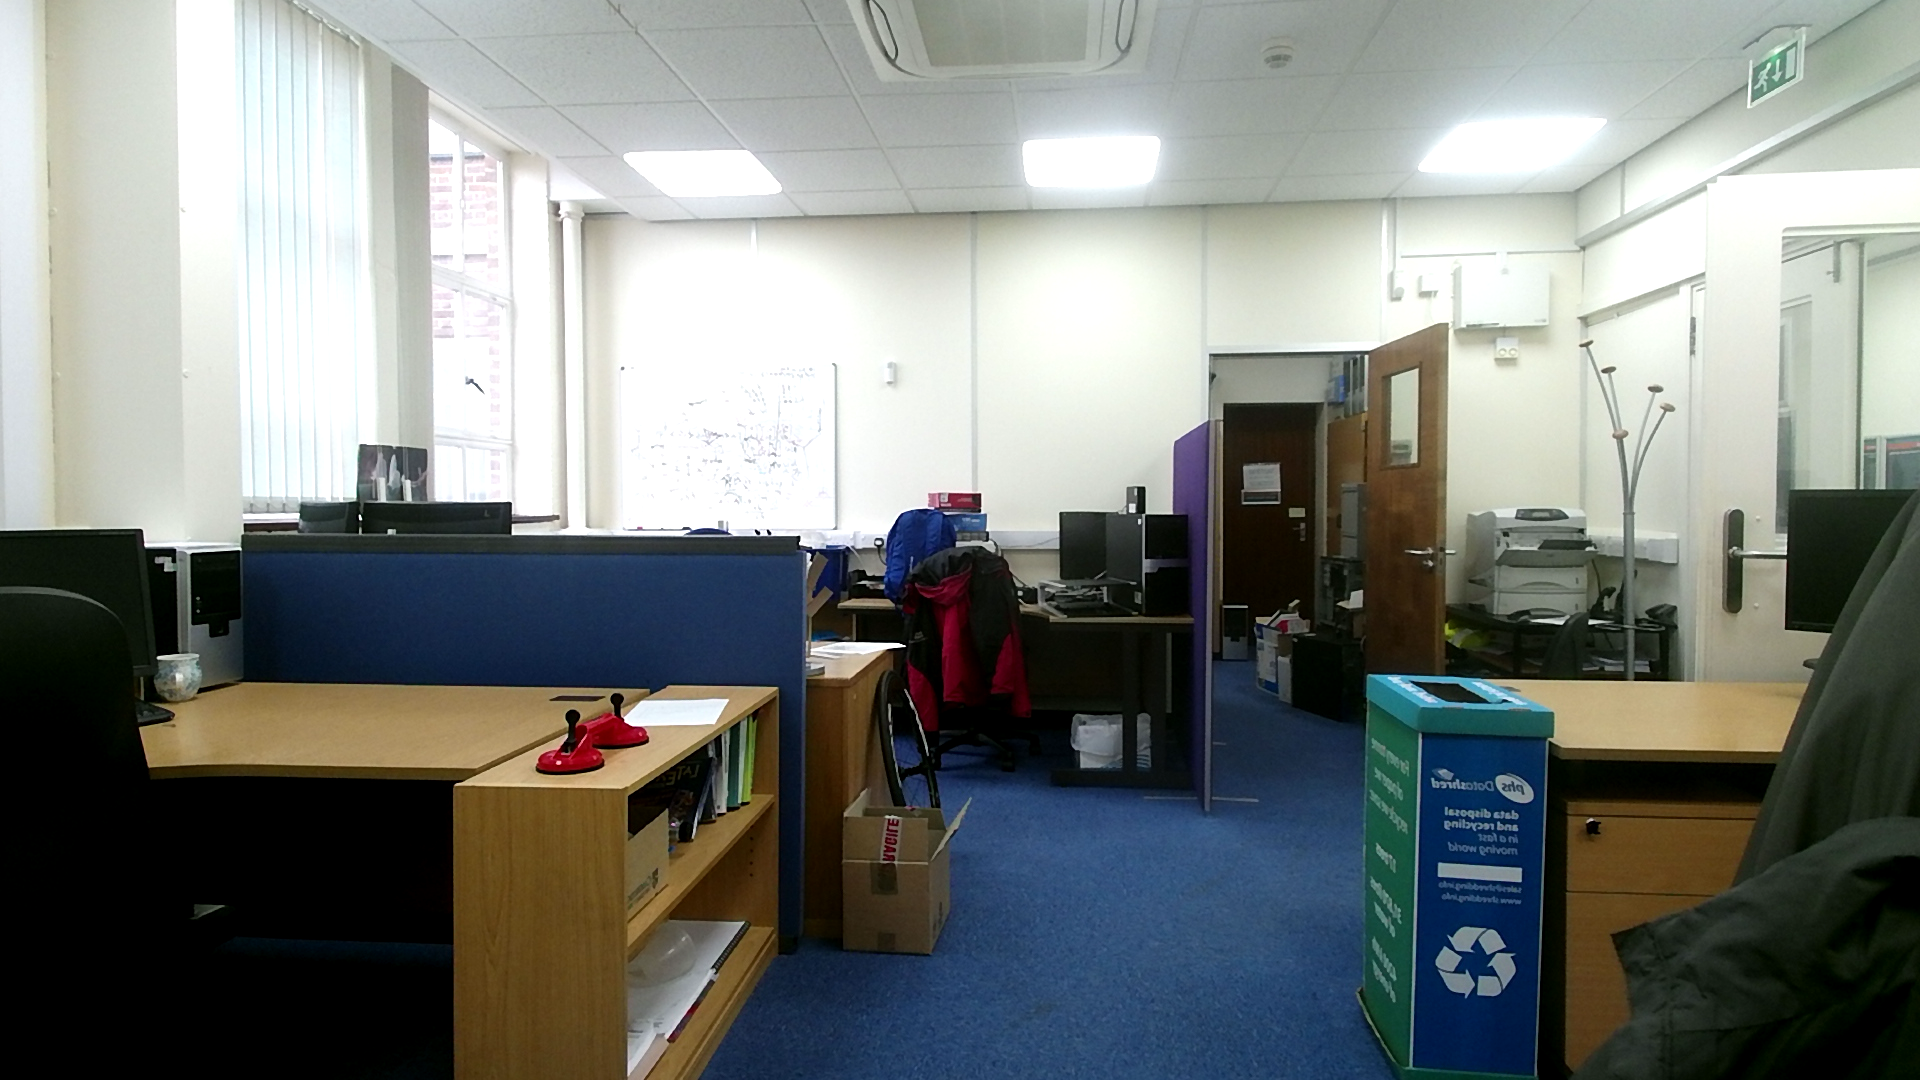

In [7]:
color.to_image()

You can also convert frames to NumPy-style arrays. Let's write a little helper function to neatly display monochrome images with their contrast stretched and a histogram of pixel values:

In [8]:
from copy import deepcopy

def show_monochrome_image(image, no_data_value=None):
    # Custom color map which sets invalid values to mid-red.
    cmap = deepcopy(plt.cm.gray)
    cmap.set_bad((0.5, 0., 0.), 1.0)
    
    # Make sure the image is at least 2D and set no-data values to NaN.
    image = np.atleast_2d(image)
    if no_data_value is not None:
        image[image == no_data_value] = np.nan
        
    # Find all the non-NaN values for computing the black and white levels.
    image_flat = image[np.isfinite(image)]
    black, white = np.percentile(image_flat, 5), np.percentile(image_flat, 95)

    # Create the figure.
    plt.figure(figsize=(14, 5))

    # Show the image.
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap=cmap, clim=(black, white))
    plt.axis('off')
    plt.title('Image')

    # Show the histogram
    plt.subplot(1, 2, 2)
    plt.hist(image_flat, bins=np.linspace(black, white, 512), histtype='step')
    plt.xlim(black, white)
    plt.title('Histogram')
    plt.xlabel('Value')
    plt.ylabel('Count')

Show off this function by plotting the IR image:

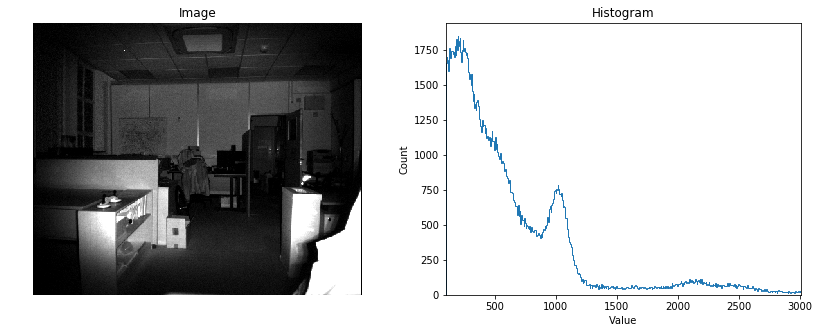

In [9]:
show_monochrome_image(ir.to_array())

The function we wrote also handles images with "no data" values. In the case of the depth image, "no data" is represented by 0. The depth values themselves are in millimetres.

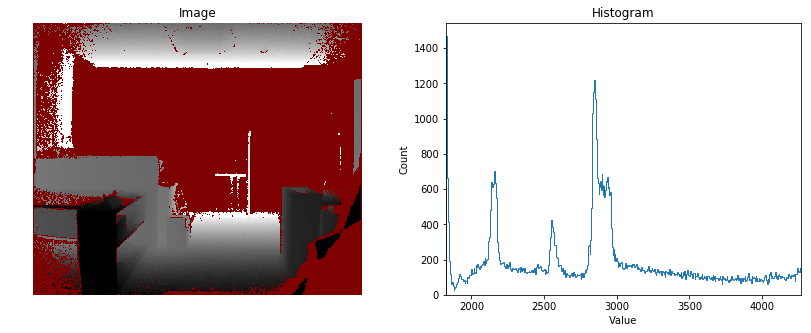

In [10]:
show_monochrome_image(depth.to_array(), no_data_value=0)

Devices come with a factory calibration which can be used to register the depth and RGB images together. This is accessed via the ``registration`` attribute on a ``Device`` object. Registration is performed by the ``.apply()`` method:

In [11]:
help(device.registration.apply)

Help on method apply in module freenect2:

apply(rgb, depth, enable_filter=True, with_big_depth=False) method of freenect2.Registration instance
    Take an RGB and Depth image and return tuple with the undistorted
    depth image and color image rectified onto depth.
    
    Args:
        rgb (:py:class:`.Frame`): RGB frame received from device
        depth (:py:class:`.Frame`): Depth frame received from device
        enable_filter (bool): If true, filter out pixels not visible in
            both cameras.
        with_big_depth (bool): If true, also return a 1920x1082 mapping of
            depth onto the color map. The top and bottom rows are blank.
    
    Returns:
        A :py:class:`Frame` pair representing the undistorted depth and
        registered RGB frames.



Let's use it to register our RGB and depth frames.

In [12]:
depth_rect, color_rect = device.registration.apply(color, depth)

We can see what the undistorted (or "rectified") RGB looks like:

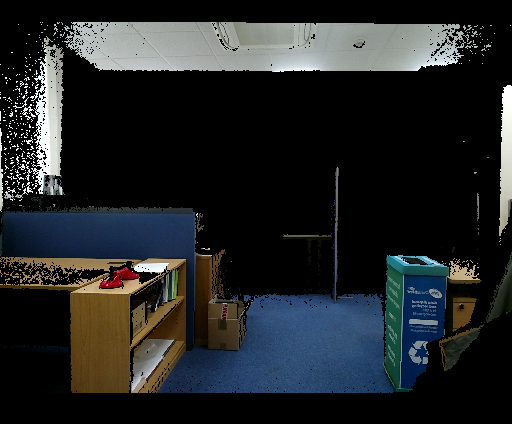

In [13]:
color_rect.to_image()

The device registration also comes with a little utility function to write a rectified depth map and (optionally) RGB image to a *Point Cloud Library* compatible PCD file.

In [14]:
with open('example.pcd', 'wb') as output_file:
    device.registration.write_pcd(output_file, depth_rect, color_rect)

The *Point Cloud Library* comes with lots of useful utilities. For example, we can estimate the normals directly from the cloud:

In [ ]:
!pcl_normal_estimation example.pcd example_w_normals.pcd -radius 5

Estimate surface normals using NormalEstimation. For more information, use: pcl_normal_estimation -h
Estimating normals with a k/radius/smoothing size of: 0 / 5.000000 / 5.000000
> Computed normals in 53 ms for 217088 points.


There is also a viewer for the point clouds.

In [ ]:
!pcl_viewer example_w_normals.pcd 

The viewer window provides interactive commands; for help, press 'h' or 'H' from within the window.
> Loading example_w_normals.pcd [done, 146 ms : 217088 points]
Available dimensions: normal_x normal_y normal_z curvature x y z rgb


There's a lot more to the ``freenect2`` bindings. See more in the documentation at https://rjw57.github.io/freenect2-python/.